In [129]:
import sys
sys.path.append("..")

 
import pandas as pd
import numpy as np
import itertools
from pyfantom.signature_tools import *
import seaborn as sns
from pylab import * 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [130]:
col_vars = pd.read_csv("../data/column_vars.processed.csv", index_col=0)

In [131]:
fine = col_vars.loc[col_vars["sample_type"] == "primary cell", "name"].apply(lambda x: x.split(',')[0].strip().lower())
len(fine), len(fine.unique())

(783, 219)

In [132]:
coarse = fine.apply(lambda x: x.split("-")[0].strip())
len(coarse), len(coarse.unique())

(783, 107)

remove samples that do not differ

In [133]:
differing = fine != coarse
fine = fine[differing]
coarse = coarse[differing]
len(fine.unique()), len(coarse.unique())

(138, 29)

## Load gene expression data

In [134]:
gct = pd.read_csv("../data/hg19.cage_peak_phase1and2combined_tpm_ann.osc.txt", comment="#", header=0, sep="\t")
gct = gct[2:]
gct_genes = gct[~pd.isnull(gct['hgnc_id'])]
gct_genes.set_index('hgnc_id', inplace=True)
expr = gct_genes.ix[:,7:]
expr.shape

(87554, 1828)

In [135]:
aggr_coarse = aggregate_dataframe(expr, coarse)

In [136]:
aggr_fine = aggregate_dataframe(expr, fine)

In [137]:
sig_coarse = get_gini_signatures(aggr_coarse, max_rk=3)
sig_fine = get_gini_signatures(aggr_fine, max_rk=10)

In [138]:
def jaccard_mat(sigs1, sigs2):
    for name1, genes1 in sigs1.items():
        for name2, genes2 in sigs2.items():
            yield (name1, name2, jaccard_ind(genes1, genes2))

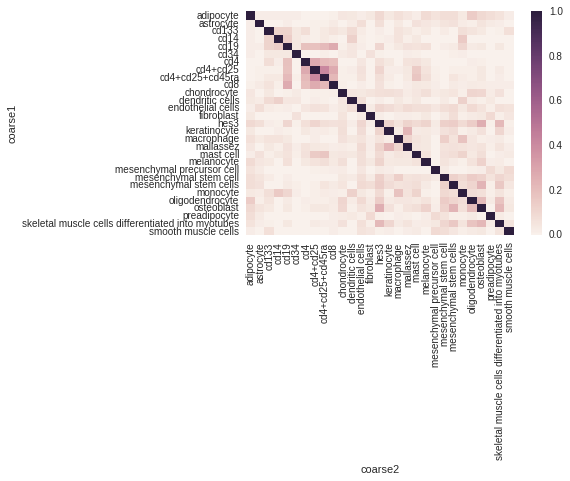

In [139]:
df = pd.DataFrame(jaccard_mat(sig_coarse, sig_coarse), columns=("coarse1", "coarse2", "jaccard"))
sns.heatmap(df.pivot(*df.columns))

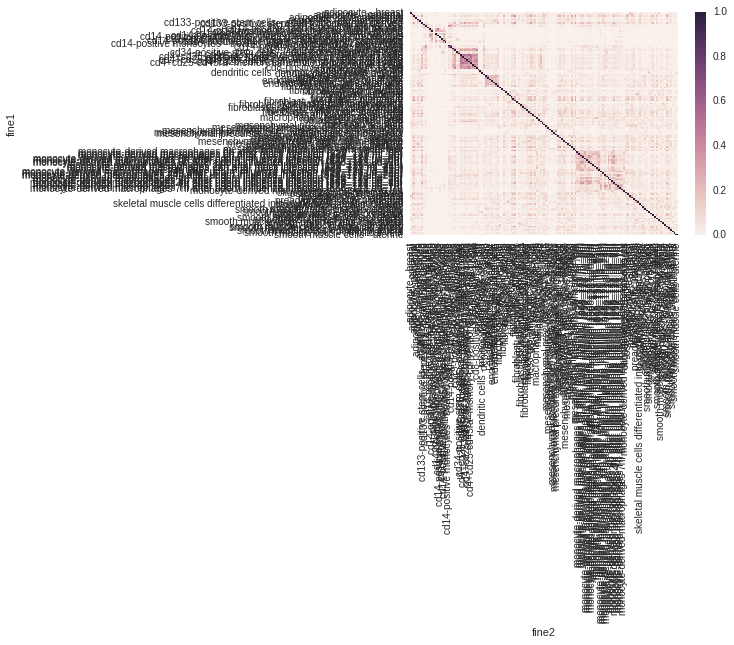

In [140]:
df = pd.DataFrame(jaccard_mat(sig_fine, sig_fine), columns=("fine1", "fine2", "jaccard"))
sns.heatmap(df.pivot(*df.columns))

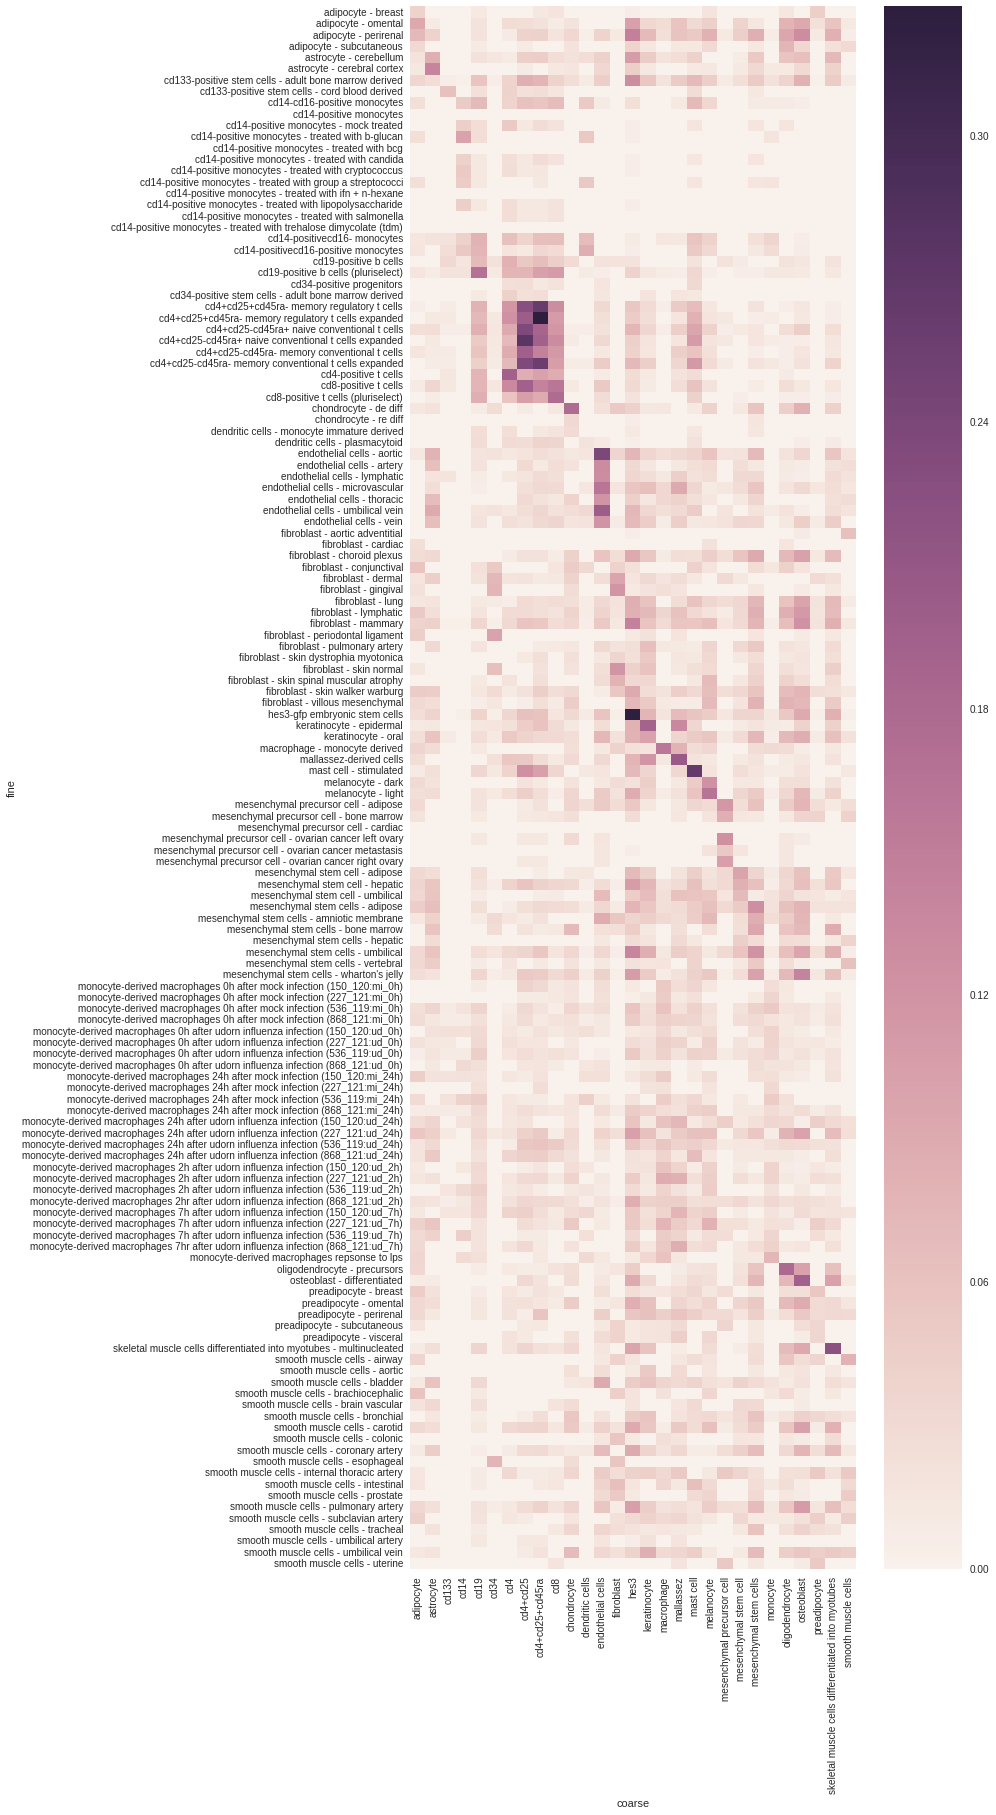

In [141]:
fig, ax = subplots(figsize=(10, 28))
df = pd.DataFrame(jaccard_mat(sig_fine, sig_coarse), columns=("fine", "coarse", "jaccard"))
sns.heatmap(df.pivot(*df.columns))

Do the same with aggregated signatures

In [142]:
sig_fine_merged = {
    tissue : set()
    for tissue in sig_coarse
}

In [143]:
for tissue, sig in sig_fine.items(): 
    sig_fine_merged[tissue.split("-")[0].strip()] |= sig

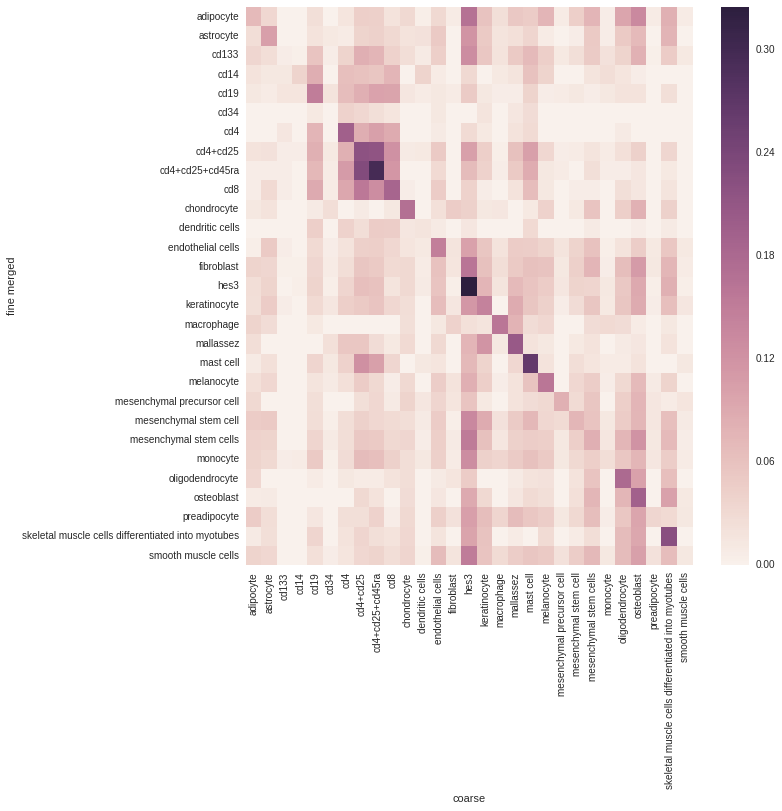

In [144]:
fig, ax = subplots(figsize=(10, 10))
df = pd.DataFrame(jaccard_mat(sig_fine_merged, sig_coarse), columns=("fine merged", "coarse", "jaccard"))
sns.heatmap(df.pivot(*df.columns))